## Methods

Making sure we are in the data1030 environment before proceeding.

In [3]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.
[ OK ] xgboost version 1.5.1 is installed.
[ OK ] shap version 0.40.0 is installed.


### Importing Packages and Data

In [4]:
#important packages
import pandas as pd
import numpy as np
import scipy.stats as st 

#visualization packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing packages
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#model selection packages
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.model_selection import ParameterGrid

#import metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import math
from math import sqrt

#model packages
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost

import warnings
warnings.filterwarnings('ignore')

In [5]:
#loading in the dataframe from EDA
%store -r df

### Splitting

In [7]:
#identifying our target variable y
y = df['distress_score']
#all other columns are features 
X = df.loc[:, df.columns != 'distress_score'] 

We can perform a basic split because we have iid data, no time series, and no group structure.

In [70]:
#splitting the data
random_state = 42

#first split to separate out the training set
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6, random_state = random_state)

#second split to separate out the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other, train_size = 0.5, random_state = random_state)
    
print('X_train shape before preprocessing:', X_train.shape)
print('X_val shape before preprocessing:', X_val.shape)
print('X_test shape before preprocessing:', X_test.shape)

X_train shape before preprocessing: (15459, 19)
X_val shape before preprocessing: (5153, 19)
X_test shape before preprocessing: (5154, 19)


#### Baseline

In [71]:
#identifying our target variable y
y = df['distress_score']

#getting the mean of our target
y_bar = np.mean(y)
y_bar = np.repeat(y_bar, len(y))

In [99]:
baseline = np.sqrt(mean_squared_error(y, y_bar))

In [100]:
print('The Baseline rmse score is a distress score of:', baseline)

The Baseline rmse score is a distress score of: 28.8674814735777


### Preprocessing

In [74]:
#checking out columns to create lists of types of features
X.columns

Index(['state', 'census_region', 'community_class', 'total_population',
       '%_adults_wo_hs', 'poverty_rate', '%_adults_not_employed',
       'vacancy_rate', 'median_income_ratio', '%_change_in_employment',
       '%_change_in_establishments', '%_pop_non_hispanic_white',
       '%_pop_hispanic_or_latino', '%_pop_black_or_african_american',
       '%_pop_american_indian_or_alaska_native',
       '%_pop_asian_or_pacific_islander', '%_pop_other_race',
       '%_pop_foreign_born', '%_pop_bachelors_degree_or_higher'],
      dtype='object')

In [75]:
#list of our features by what transformer they need
onehot_ftrs = ['state', 'census_region', 'community_class']

std_ftrs = ['total_population', '%_adults_wo_hs', 'poverty_rate', \
            '%_adults_not_employed', 'vacancy_rate', 'median_income_ratio', \
            '%_change_in_employment', '%_change_in_establishments', \
            '%_pop_non_hispanic_white', '%_pop_hispanic_or_latino', \
            '%_pop_black_or_african_american', '%_pop_american_indian_or_alaska_native', \
            '%_pop_asian_or_pacific_islander', '%_pop_other_race', '%_pop_foreign_born', \
            '%_pop_bachelors_degree_or_higher']


#collecting all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)
    ]
)

In [76]:
mod = Pipeline(steps=[('preprocessor', preprocessor)])
mod.fit(X_train,y_train)

X_train_prep = pd.DataFrame(mod.fit_transform(X_train)) 
X_test_prep = pd.DataFrame(mod.transform(X_test))
X_val_prep = pd.DataFrame(mod.transform(X_val))

#extracting column names and replacing
column_names = mod.steps[0][1].get_feature_names_out()
X_train_df = pd.DataFrame(X_train_prep)
X_train_df.columns = column_names
# print(X_train_df)

In [77]:
print('X_train shape after preprocessing:', X_train_prep.shape)
print('X_val shape after preprocessing:', X_val_prep.shape)
print('X_test shape after preprocessing:', X_test_prep.shape)

X_train shape after preprocessing: (15459, 75)
X_val shape after preprocessing: (5153, 75)
X_test shape after preprocessing: (5154, 75)


### ML Pipeline

In [8]:
#feature selection
X = df.loc[:, ((df.columns != "distress_score"))]
y = df["distress_score"]

In [8]:
#list of our features by what transformer they need
onehot_ftrs = ['state', 'census_region', 'community_class']

std_ftrs = ['total_population', '%_adults_wo_hs', 'poverty_rate', \
            '%_adults_not_employed', 'vacancy_rate', 'median_income_ratio', \
            '%_change_in_employment', '%_change_in_establishments', \
            '%_pop_non_hispanic_white', '%_pop_hispanic_or_latino', \
            '%_pop_black_or_african_american', '%_pop_american_indian_or_alaska_native', \
            '%_pop_asian_or_pacific_islander', '%_pop_other_race', '%_pop_foreign_born', \
            '%_pop_bachelors_degree_or_higher']


#collecting all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)
    ]
)
#for now we only preprocess, later we will add other steps here
prep = Pipeline(steps=[('preprocessor', preprocessor)])

In [9]:
#main function for models
def MLpipe_RMSE(X, y, model, param_grid):
    nr_states = 5
    test_scores = np.zeros(nr_states)
    final_models = []
    final_models_test_set = []
    final_models_test_set_y = []
    final_models_test_set_pred = []
    baseline_scores = np.zeros(nr_states)
    baseline_std = np.zeros(nr_states)

    # loop through the different random states
    for i in range(nr_states):
        print('randoms state '+str(i+1))

        #first split to separate out the training set
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,shuffle=True,random_state=42*i)
        
        #second split to separate out the validation and test sets
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,shuffle=True,random_state=42*i)
        
        #preprocess the sets
        X_train_prep = prep.fit_transform(X_train)
        X_val_prep = prep.transform(X_val)
        X_test_prep = prep.transform(X_test)

        #the validation scores are necessary to select the best model
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []
        
        #calculating a baseline score for each model
        y_bar = np.mean(y_test)
        y_bar = np.repeat(y_bar, len(y_test))
        baseline = np.sqrt(mean_squared_error(y_test, y_bar))
        baseline_scores[i] = baseline
        baseline_std[i] = np.std(y_test)
        print('Baseline RMSE score:', baseline_scores[i])


        #loop through all combinations of hyperparameter combos
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            if model in [Lasso, Ridge, ElasticNet, RandomForestRegressor]:
                mod = model(**params,random_state=42*i)
            elif model == RandomForestRegressor:
                mod = model(**params, random_state=42*i, n_estimators=100)
            else:
                mod = model(**params)
            #fitting the model
            mod.fit(X_train_prep, y_train)
            models.append(mod)
            
            #calculate train and validation Root Mean Square Error scores
            y_val_pred = mod.predict(X_val_prep)
            val_score[p] = np.sqrt(mean_squared_error(y_val,y_val_pred))
        
        
        #print out model parameters
        print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_score)])
        print('corresponding validation score:',np.min(val_score))
        #collect and save the best model
        final_models.append(models[np.argmin(val_score)])

        #calculate and save the test score
        y_test_pred = final_models[-1].predict(X_test_prep)
        test_scores[i] = np.sqrt(mean_squared_error(y_test,y_test_pred))
        print('RMSE_test_score:',test_scores[i])
        print('the score is {} standard deviations from the baseline'.format((baseline_scores[i]-test_scores[i])/baseline_std[i]))
        print('\n')
    
    
    mean_test_score = np.average(test_scores)
    std_test_score = np.std(test_scores)
    baseline_mean = np.average(baseline_scores)
    baseline_std = np.average(baseline_std)
    best_final_models=final_models[np.argmin(test_scores)]
    best_scores=test_scores[np.argmin(test_scores)]
    stddev_away = (baseline_mean-mean_test_score)/baseline_std
    
    #print out mean and std of test scores
    print('mean of RMSE test scores:', mean_test_score)
    print('standard deviation of RMSE test scores:', std_test_score)
    print('mean of baseline RMSE is:', baseline_mean)
    print('the score is {} standard deviations from the baseline'.format((np.mean(baseline_scores)-np.mean(test_scores))/np.mean(baseline_std)))

    
    return mean_test_score, std_test_score, baseline_mean, baseline_std, stddev_away, best_final_models, best_scores
    

In [10]:
#Lasso
model = Lasso

#params for lasso
param_grid = {
    'alpha': np.logspace(-3,3,10),
    'max_iter':[1000]}

lasso_mean, lasso_std, lasso_baseline_mean, lasso_baseline_std, lasso_stddev_away, lasso_best_models, lasso_best_RMSE = MLpipe_RMSE(
    X, y, model, param_grid)

randoms state 1
Baseline RMSE score: 29.057803434928164
best model parameters: {'max_iter': 1000, 'alpha': 2.154434690031882}
corresponding validation score: 11.882681828162058
RMSE_test_score: 11.646984110331438
the score is 0.5991787838879973 standard deviations from the baseline


randoms state 2
Baseline RMSE score: 29.07422030193
best model parameters: {'max_iter': 1000, 'alpha': 0.004641588833612777}
corresponding validation score: 10.837487999145
RMSE_test_score: 11.160139799728956
the score is 0.6161499884147151 standard deviations from the baseline


randoms state 3
Baseline RMSE score: 28.53857707295082
best model parameters: {'max_iter': 1000, 'alpha': 2.154434690031882}
corresponding validation score: 11.724385103348459
RMSE_test_score: 11.506469390871787
the score is 0.5968099824508157 standard deviations from the baseline


randoms state 4
Baseline RMSE score: 29.244816998498777
best model parameters: {'max_iter': 1000, 'alpha': 0.021544346900318832}
corresponding validat

In [6]:
all_lasso_test_scores = [
    11.646984110331438, 11.506469390871787, 11.506469390871787, 10.41076513628011, 10.79386807461901
]

In [12]:
#Ridge
model = Ridge

#params for Ridge
param_grid = {
    'alpha': np.logspace(-3,3,10),
    'max_iter':[1000]}

ridge_mean, ridge_std, ridge_baseline_mean, ridge_baseline_std, ridge_stddev_away, ridge_best_models, ridge_best_RMSE = MLpipe_RMSE(
    X, y, model, param_grid)

randoms state 1
Baseline RMSE score: 29.057803434928164
best model parameters: {'max_iter': 1000, 'alpha': 1000.0}
corresponding validation score: 11.995055692485163
RMSE_test_score: 10.927371345197274
the score is 0.6239436552846139 standard deviations from the baseline


randoms state 2
Baseline RMSE score: 29.07422030193
best model parameters: {'max_iter': 1000, 'alpha': 46.41588833612773}
corresponding validation score: 10.836174396950728
RMSE_test_score: 11.162886840654245
the score is 0.6160555046797512 standard deviations from the baseline


randoms state 3
Baseline RMSE score: 28.53857707295082
best model parameters: {'max_iter': 1000, 'alpha': 1000.0}
corresponding validation score: 11.859814757426934
RMSE_test_score: 10.823611995794376
the score is 0.6207375032004271 standard deviations from the baseline


randoms state 4
Baseline RMSE score: 29.244816998498777
best model parameters: {'max_iter': 1000, 'alpha': 215.44346900318823}
corresponding validation score: 11.1487793748

In [7]:
all_ridge_test_scores = [
    10.927371345197274, 11.162886840654245, 10.823611995794376, 10.39702331066179, 10.794112399237873
]

In [13]:
#ElasticNet
model = ElasticNet

#params for elasticnet
param_grid = {
    'alpha': np.logspace(-2,2,10),
    'l1_ratio': np.linspace(0,1,10)[1:-1]}

en_mean, en_std, en_baseline_mean, en_baseline_std, en_stddev_away, en_best_models, en_best_RMSE = MLpipe_RMSE(
    X, y, model, param_grid)

randoms state 1
Baseline RMSE score: 29.057803434928164
best model parameters: {'l1_ratio': 0.8888888888888888, 'alpha': 0.5994842503189409}
corresponding validation score: 11.942942553112363
RMSE_test_score: 11.140498199052265
the score is 0.6166090728777825 standard deviations from the baseline


randoms state 2
Baseline RMSE score: 29.07422030193
best model parameters: {'l1_ratio': 0.1111111111111111, 'alpha': 0.01}
corresponding validation score: 10.8367100625927
RMSE_test_score: 11.175491687283309
the score is 0.6156219643647174 standard deviations from the baseline


randoms state 3
Baseline RMSE score: 28.53857707295082
best model parameters: {'l1_ratio': 0.8888888888888888, 'alpha': 0.5994842503189409}
corresponding validation score: 11.78459210119598
RMSE_test_score: 11.016114427233177
the score is 0.613992162290587 standard deviations from the baseline


randoms state 4
Baseline RMSE score: 29.244816998498777
best model parameters: {'l1_ratio': 0.7777777777777777, 'alpha': 0.

In [8]:
all_en_test_scores = [
    11.140498199052265, 11.175491687283309, 11.016114427233177, 10.381742287931212, 10.812229234516957
]

In [14]:
#RandomForestRegressor
model = RandomForestRegressor

#params for randomforestregressor
param_grid = {
    'max_depth': [1,3,10,30,70],
    'max_features': [0.25, 0.5,0.75,1.0]} 

rf_mean, rf_std, rf_baseline_mean, rf_baseline_std, rf_stddev_away, rf_best_models, rf_best_RMSE = MLpipe_RMSE(
    X, y, model, param_grid)

randoms state 1
Baseline RMSE score: 29.057803434928164
best model parameters: {'max_features': 0.5, 'max_depth': 30}
corresponding validation score: 3.2001350876602395
RMSE_test_score: 3.1345751411757767
the score is 0.8921262184116799 standard deviations from the baseline


randoms state 2
Baseline RMSE score: 29.07422030193
best model parameters: {'max_features': 0.5, 'max_depth': 30}
corresponding validation score: 3.1600984593295043
RMSE_test_score: 3.1336584096431945
the score is 0.892218660479945 standard deviations from the baseline


randoms state 3
Baseline RMSE score: 28.53857707295082
best model parameters: {'max_features': 0.5, 'max_depth': 30}
corresponding validation score: 3.123603287700386
RMSE_test_score: 3.220067685093774
the score is 0.8871678963929218 standard deviations from the baseline


randoms state 4
Baseline RMSE score: 29.244816998498777
best model parameters: {'max_features': 0.5, 'max_depth': 30}
corresponding validation score: 3.1410310896320848
RMSE_tes

In [135]:
#storing the best performing model
%store rf_best_models

Stored 'rf_best_models' (RandomForestRegressor)


In [9]:
all_rf_test_scores = [
    3.1345751411757767, 3.1336584096431945, 3.220067685093774, 3.0466022057685875, 3.159567737881243
]

In [15]:
#KNeighborRegressor
model = KNeighborsRegressor

#params for kneighborsregressor
param_grid = {
   'n_neighbors': np.arange(1,20,4)}

knn_mean, knn_std, knn_baseline_mean, knn_baseline_std, knn_stddev_away, knn_best_models, knn_best_RMSE = MLpipe_RMSE(
    X, y, model, param_grid)

randoms state 1
Baseline RMSE score: 29.057803434928164
best model parameters: {'n_neighbors': 13}
corresponding validation score: 7.7609796067146455
RMSE_test_score: 7.960995743832134
the score is 0.7260289903997758 standard deviations from the baseline


randoms state 2
Baseline RMSE score: 29.07422030193
best model parameters: {'n_neighbors': 9}
corresponding validation score: 8.145749943884057
RMSE_test_score: 8.1471841918523
the score is 0.719779787480269 standard deviations from the baseline


randoms state 3
Baseline RMSE score: 28.53857707295082
best model parameters: {'n_neighbors': 13}
corresponding validation score: 7.772048900282973
RMSE_test_score: 7.828052979237715
the score is 0.7257027580867993 standard deviations from the baseline


randoms state 4
Baseline RMSE score: 29.244816998498777
best model parameters: {'n_neighbors': 13}
corresponding validation score: 7.83004669662097
RMSE_test_score: 8.041097222772962
the score is 0.7250419716018146 standard deviations from 

In [10]:
all_knn_test_scores = [
    7.960995743832134, 8.1471841918523, 7.828052979237715, 8.041097222772962, 7.995920816108874
]

In [16]:
#SVR
model = SVR

#params for svr
param_grid = {
   'gamma': [1e-1, 1e1, 1e3],
   'C': [1e-1, 1e0, 1e1]}

svr_mean, svr_std, svr_baseline_mean, svr_baseline_std, svr_stddev_away, svr_best_models, svr_best_RMSE = MLpipe_RMSE(
    X, y, model, param_grid)

randoms state 1
Baseline RMSE score: 29.057803434928164
best model parameters: {'gamma': 0.1, 'C': 10.0}
corresponding validation score: 3.9986597313741443
RMSE_test_score: 4.131276181081323
the score is 0.8578255858075139 standard deviations from the baseline


randoms state 2
Baseline RMSE score: 29.07422030193
best model parameters: {'gamma': 0.1, 'C': 10.0}
corresponding validation score: 4.230507701447243
RMSE_test_score: 4.074153696125322
the score is 0.8598705776520902 standard deviations from the baseline


randoms state 3
Baseline RMSE score: 28.53857707295082
best model parameters: {'gamma': 0.1, 'C': 10.0}
corresponding validation score: 4.000955070938915
RMSE_test_score: 3.887837950333525
the score is 0.8637690330391959 standard deviations from the baseline


randoms state 4
Baseline RMSE score: 29.244816998498777
best model parameters: {'gamma': 0.1, 'C': 10.0}
corresponding validation score: 3.8605503218719703
RMSE_test_score: 3.7066909907380983
the score is 0.87325306255

In [11]:
all_svr_test_scores = [
    4.131276181081323, 4.074153696125322, 3.887837950333525, 3.7066909907380983, 3.9179190898810603
]

### Results

#### Variation between Random States for each Model

In [12]:
#collecting all test scores for each random state for each model in a df
all_models_df = pd.DataFrame({
    'lasso': all_lasso_test_scores,
    'ridge': all_ridge_test_scores,
    'elasticnet': all_en_test_scores,
    'randomforest': all_rf_test_scores,
    'knn': all_knn_test_scores,
    'svr': all_svr_test_scores})

In [13]:
#adjusting the index so that it matches the row's random state that produced the scores
all_models_df.index = np.arange(1, len(all_models_df) + 1)

In [51]:
all_models_df

,lasso,ridge,elasticnet,randomforest,knn,svr
1,11.646984,10.927371,11.140498,3.134575,7.960996,4.131276
2,11.506469,11.162887,11.175492,3.133658,8.147184,4.074154
3,11.506469,10.823612,11.016114,3.220068,7.828053,3.887838
4,10.410765,10.397023,10.381742,3.046602,8.041097,3.706691
5,10.793868,10.794112,10.812229,3.159568,7.995921,3.917919


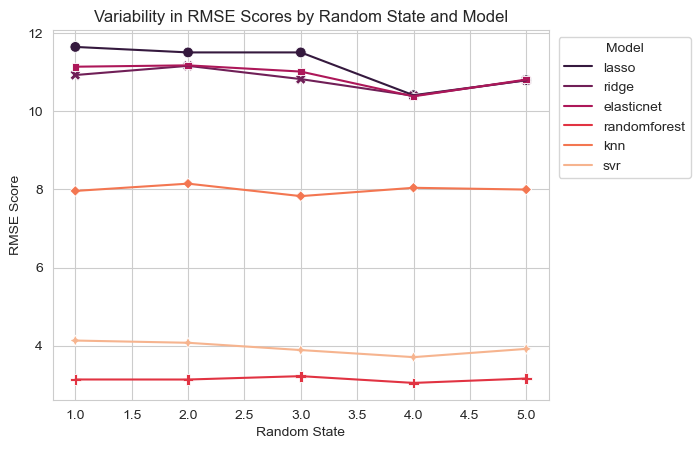

In [69]:
#visualization for variability in test scores between random states and models
# sns.reset_defaults()
sns.set_style("whitegrid")
# sns.set_palette("ch:s=-.2,r=.6")
sns.set_palette("rocket")

ax = sns.lineplot(data=all_models_df, dashes=False)
sns.scatterplot(data=all_models_df, legend=False, s=60)
ax.set_xlabel("Random State")
ax.set_ylabel("RMSE Score")
ax.set_title("Variability in RMSE Scores by Random State and Model")
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right', title='Model')

plt.show()

#### Visualizing Best Test Scores vs Baseline

In [73]:
#saving all model means as a list
model_means = []
#all models returned same baseline mean bc of same random states
model_means.append(lasso_baseline_mean)
model_means.append(lasso_mean)
model_means.append(ridge_mean)
model_means.append(en_mean)
model_means.append(rf_mean)
model_means.append(knn_mean)
model_means.append(svr_mean)

#saving all model std as a list
model_std = []
model_std.append(lasso_std)
model_std.append(ridge_std)
model_std.append(en_std)
model_std.append(rf_std)
model_std.append(knn_std)
model_std.append(svr_std)

#saving all model standard deviations away from the baseline
stddev_away = []
stddev_away.append(lasso_stddev_away)
stddev_away.append(ridge_stddev_away)
stddev_away.append(en_stddev_away)
stddev_away.append(rf_stddev_away)
stddev_away.append(knn_stddev_away)
stddev_away.append(svr_stddev_away)

In [74]:
#storing the lists of means and standard deviations
%store model_means
%store model_std
%store stddev_away

In [75]:
%store -r model_means
%store -r model_std
%store -r stddev_away

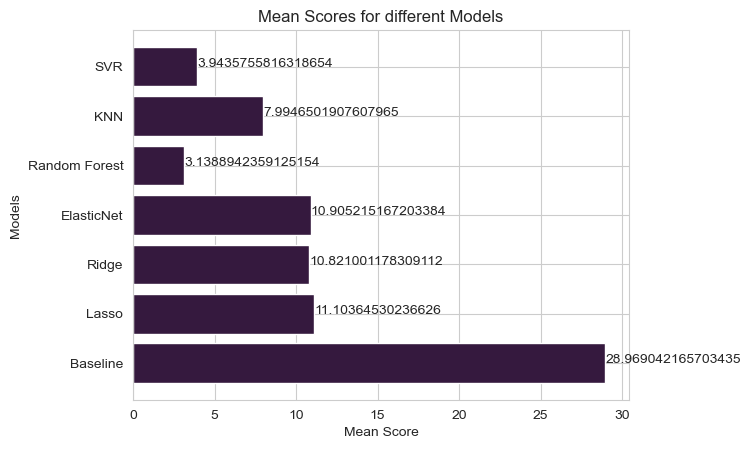

In [76]:
#visualizing mean of test scores
plt.barh(range(7), model_means)
plt.yticks(range(7), ["Baseline", "Lasso", "Ridge", "ElasticNet", "Random Forest", "KNN", "SVR"])
plt.xlabel("Mean Score")
plt.ylabel("Models")
plt.title("Mean Scores for different Models")
for index, value in enumerate(model_means):
    plt.text(value, index, str(value))
# plt.savefig('../figures/model_means.png', bbox_inches='tight')
plt.show()

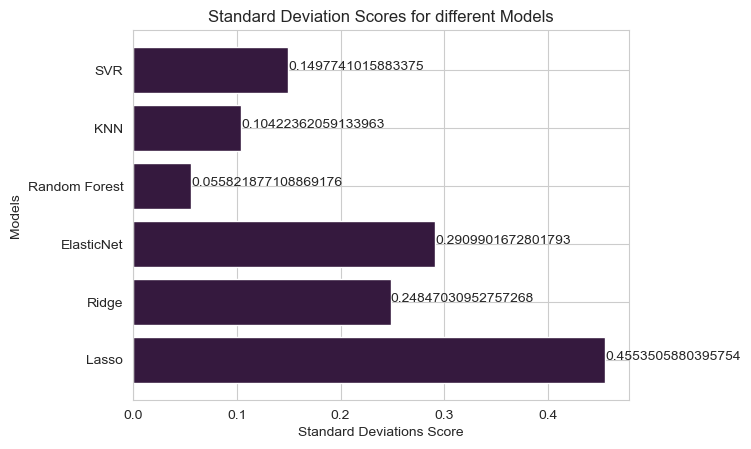

In [77]:
#visualizing standard deviation scores
# stddev_list = [lasso_std, ridge_std, EN_std, rf_std, svr_stddev, knn_std]
plt.barh(range(6), model_std)
plt.yticks(range(6), ["Lasso", "Ridge", "ElasticNet", "Random Forest", "KNN", "SVR"])
plt.xlabel("Standard Deviations Score")
plt.ylabel("Models")
plt.title("Standard Deviation Scores for different Models")
for index, value in enumerate(model_std):
    plt.text(value, index, str(value))
# plt.savefig('../figures/model_std.png', bbox_inches='tight')
plt.show();

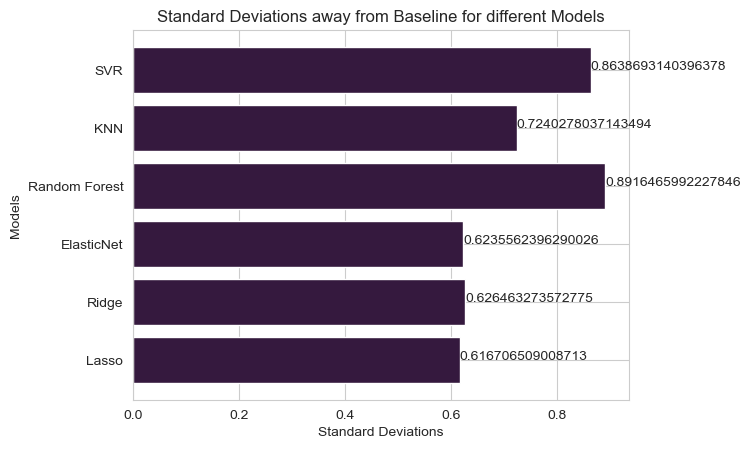

In [78]:
#visualizing standard deviations away from baseline for each model
plt.barh(range(6), stddev_away)
plt.yticks(range(6), ["Lasso", "Ridge", "ElasticNet", "Random Forest", "KNN", "SVR"])
plt.xlabel("Standard Deviations")
plt.ylabel("Models")
plt.title("Standard Deviations away from Baseline for different Models")
for index, value in enumerate(stddev_away):
    plt.text(value, index, str(value))
# plt.savefig('../figures/model_std_from_baseline.png', bbox_inches='tight')
plt.show();

Interpreting the RMSE: model score says we can confidently be within <score> units to the actual distress score